# Importing Python libraries

In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from prettytable import PrettyTable
import yfinance as yf

import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import normaltest
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">  
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
<h1><center><strong> TSLA Stock</strong></center></h1>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
    <h6>"</h6>
        
</div>

# ------------------------------------------------------------------------------------------------------

# Loading dataset

In [6]:
data = yf.Ticker("TSLA")
data = data.history(period='10y')

In [2]:
# data = pd.read_csv('TSLA_Stock.csv')

# -----------------------------------------------------------------------------------------------------------

<h1><center> Modelling Arima and Sarima</center></h1>

# -----------------------------------------------------------------------------------------------------------

### Seasonality of Close price

<AxesSubplot:xlabel='Date'>

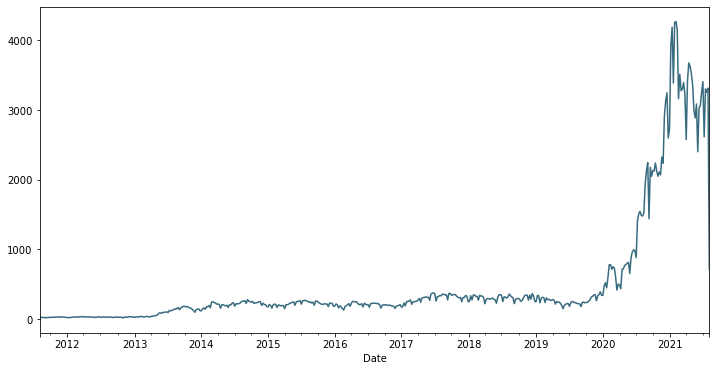

In [7]:
data['Close'] = data['Close'] * 1.0
close_1 = data['Close']
f, (ax1) = plt.subplots(1, figsize = (12, 6))
c = '#386B7F'
close_1.resample('W').sum().plot(color = c, ax = ax1)

### Stationarize the Close price data

In [8]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [9]:
def residual_plot(model):
    resid = model.resid
    print(normaltest(resid))
    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)
    sns.distplot(resid ,fit = stats.norm, ax = ax0)
    (mu, sigma) = stats.norm.fit(resid)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid, lags=40, ax=ax2)

### Close price with rolling windows

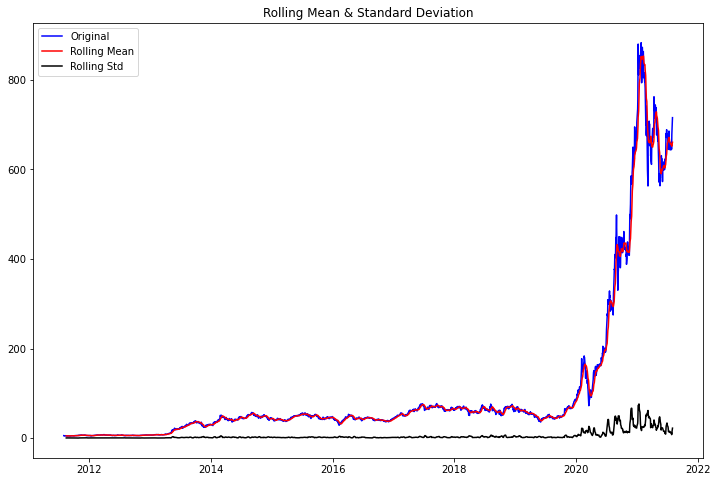

Results of Dickey-Fuller Test:
p-value = 0.9976. The series is likely non-stationary.
Test Statistic                    1.525273
p-value                           0.997615
#Lags Used                       19.000000
Number of Observations Used    2497.000000
Critical Value (1%)              -3.432972
Critical Value (5%)              -2.862698
Critical Value (10%)             -2.567387
dtype: float64


In [10]:
test_stationarity(close_1)

We are going to make data as stationary. So we want to do is take a first difference of the data and it will help to eliminate the overall trend from the data.

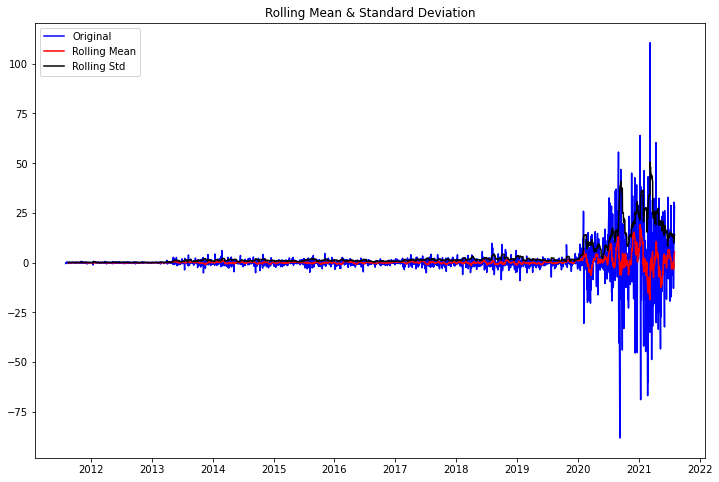

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.780224e+00
p-value                        6.764407e-17
#Lags Used                     2.000000e+01
Number of Observations Used    2.495000e+03
Critical Value (1%)           -3.432974e+00
Critical Value (5%)           -2.862699e+00
Critical Value (10%)          -2.567387e+00
dtype: float64


In [11]:
first_diff_a = close_1 - close_1.shift(1)
first_diff_a = first_diff_a.dropna(inplace = False)
test_stationarity(first_diff_a, window = 12)

### Plots of ACF and PACF

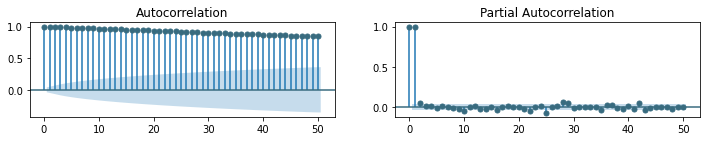

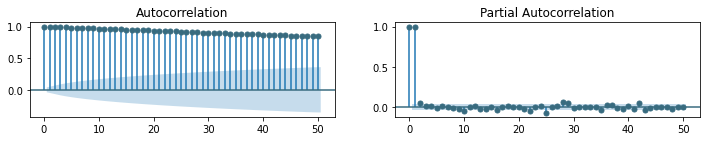

In [13]:
plt.figure(figsize = (12, 8))
plt.subplot(421); plot_acf(close_1, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(close_1, lags = 50, ax = plt.gca(), color = c)

### Splitting the data into training (first 70%) testing (latest 30%)

In [14]:
train_data, test_data = data[0:int(len(data)*0.7)], data[int(len(data)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values

### Training and testing the ARIMA model

In [15]:
history_of_train = [x for x in training_data]
predictions = []
test_records = len(test_data)
for times in range(test_records):
    arima = SARIMAX(history_of_train, order=(4,4,1))
    arima_fit = arima.fit(disp=0)
    output = arima_fit.forecast()
    pred = output[0]
    predictions.append(pred)
    test_value = test_data[times]
    history_of_train.append(test_value)

NormaltestResult(statistic=1084.5523509875868, pvalue=3.107773187356506e-236)


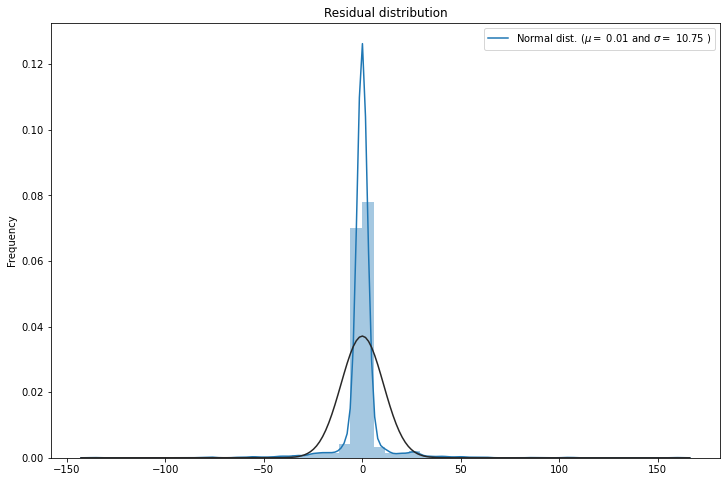

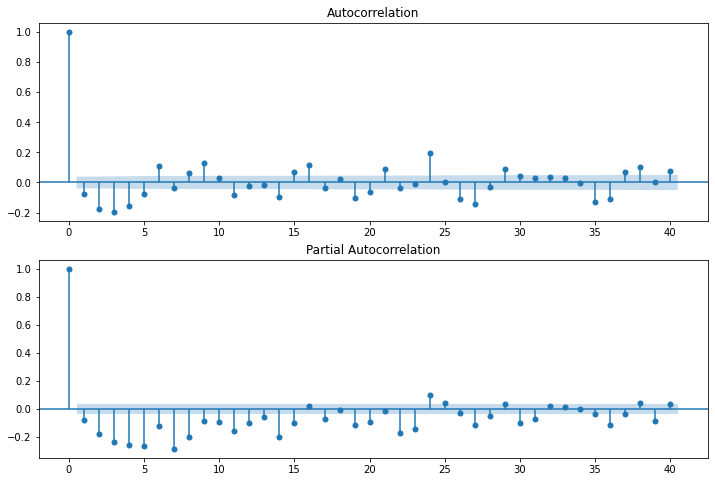

In [16]:
residual_plot(arima_fit)

### Evaluation of Arima Model on Test data

### R2

In [17]:
arima_test_rs=r2_score(test_data, predictions)
print('R Squared : ', round(arima_test_rs,3))

R Squared :  0.994


### MSE

In [18]:
arima_test_mse=mean_squared_error(test_data, predictions)
print('Mean Squared Error: ', round(arima_test_mse,3))

Mean Squared Error:  397.77


### MAE

In [19]:
arima_test_MAE=mean_absolute_error(test_data, predictions)
print('Mean Absolute Error: ', round(arima_test_MAE,3))

Mean Absolute Error:  10.752


### Predictions and Actual Stock Price

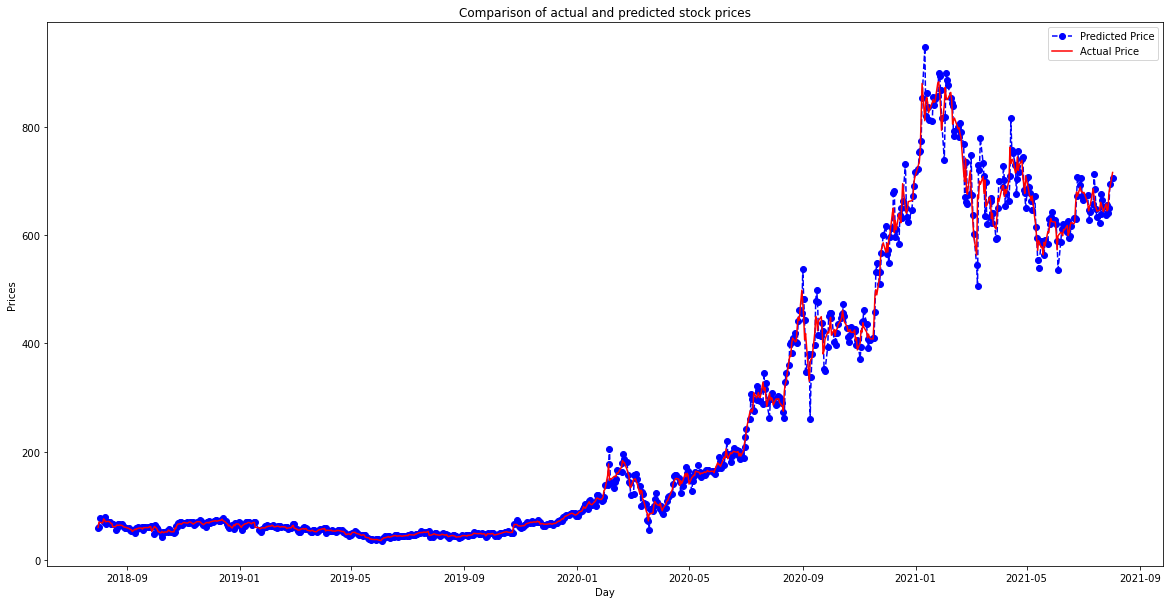

In [20]:
test_set = data[int(len(data)*0.7):].index
plt.figure(figsize=(20,10))
plt.plot(test_set, predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set, test_data, color='red', label='Actual Price')
plt.title('Comparison of actual and predicted stock prices')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()

### Training and testing the SARIMA model

In [21]:
history_of_train = [x for x in training_data]
predictions = []
test_records = len(test_data)
for times in range(test_records):
    sarima = SARIMAX(history_of_train, order=(4,4,0))
    sarima_fit = sarima.fit(disp=0)
    output = sarima_fit.forecast()
    pred = output[0]
    predictions.append(pred)
    test_value = test_data[times]
    history_of_train.append(test_value)

NormaltestResult(statistic=1205.111246584383, pvalue=2.0578691870513966e-262)


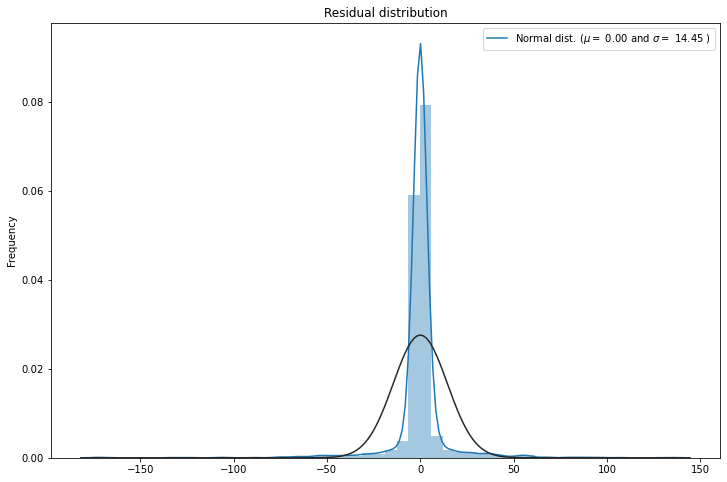

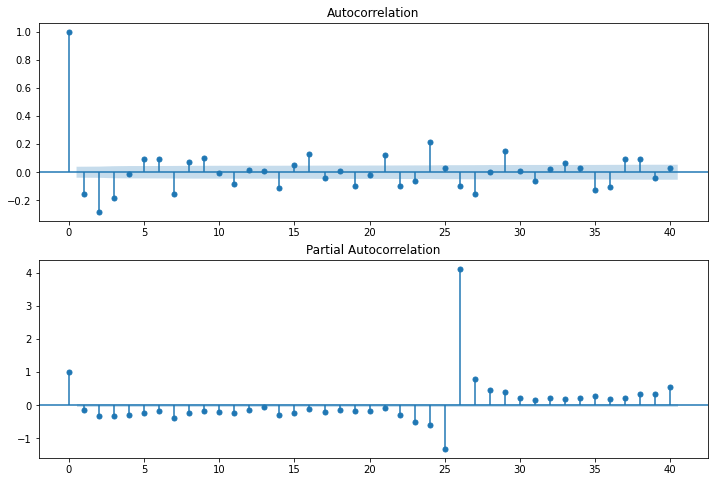

In [22]:
residual_plot(sarima_fit)

### Evaluation of sarima Model on Test data

### R2

In [25]:
sarima_test_rs=r2_score(test_data, predictions)
print('R Squared : ', round(sarima_test_rs,3))

R Squared :  0.989


### MSE

In [26]:
sarima_test_mse=mean_squared_error(test_data, predictions)
print('Mean Squared Error: ', round(sarima_test_mse,3))

Mean Squared Error:  717.193


### MAE

In [27]:
sarima_test_MAE=mean_absolute_error(test_data, predictions)
print('Mean Absolute Error: ', round(sarima_test_MAE,3))

Mean Absolute Error:  14.571


### Predictions and Actual Stock Price

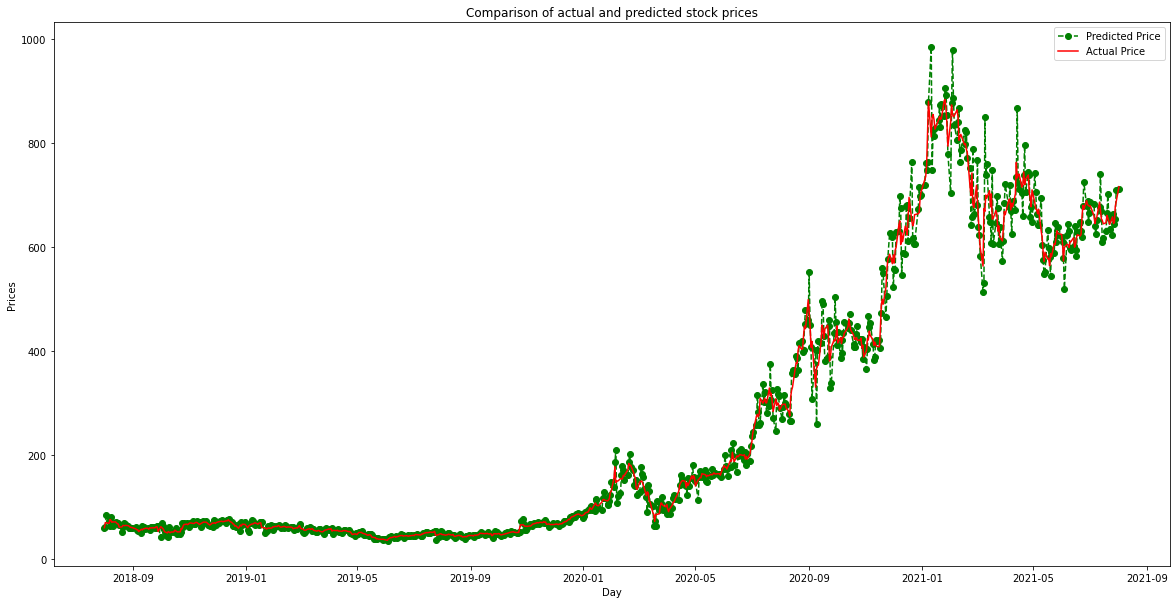

In [28]:
test_set = data[int(len(data)*0.7):].index
plt.figure(figsize=(20,10))
plt.plot(test_set, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set, test_data, color='red', label='Actual Price')
plt.title('Comparison of actual and predicted stock prices')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Comparison of all algorithms Results on R2 score

In [29]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "R2 Score"]


x.add_row(["Arima Algorithm", round(arima_test_rs,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_rs,3)])


print(x)
print('\n')



Comparison of all algorithms
+------------------+----------+
|      Model       | R2 Score |
+------------------+----------+
| Arima Algorithm  |  0.994   |
| SARIMA Algorithm |  0.989   |
+------------------+----------+




# Comparison of all algorithms Results on MSE score

In [30]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "MSE score"]


x.add_row(["Arima Algorithm", round(arima_test_mse,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_mse,3)])


print(x)
print('\n')



Comparison of all algorithms
+------------------+-----------+
|      Model       | MSE score |
+------------------+-----------+
| Arima Algorithm  |   397.77  |
| SARIMA Algorithm |  717.193  |
+------------------+-----------+




# Comparison of all algorithms Results on MAE score

In [31]:
x = PrettyTable()
print('\n')
print("Comparison of all algorithms")
x.field_names = ["Model", "MAE score"]


x.add_row(["Arima Algorithm", round(arima_test_MAE,3)])
x.add_row(["SARIMA Algorithm",  round(sarima_test_MAE,3)])

print(x)
print('\n')



Comparison of all algorithms
+------------------+-----------+
|      Model       | MAE score |
+------------------+-----------+
| Arima Algorithm  |   10.752  |
| SARIMA Algorithm |   14.571  |
+------------------+-----------+




# Graph of MSE of each algorithm

<AxesSubplot:xlabel='Algorithm'>

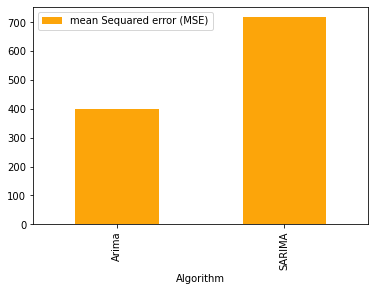

In [32]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'], 'mean Sequared error (MSE)': [arima_test_mse]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'mean Sequared error (MSE)': [sarima_test_mse]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(.2, .4, 6))
Result_Comp.plot(kind='bar',figsize=(6, 4),stacked=True, color=color, legend=True)

# Graph of R2 of each algorithm

<AxesSubplot:xlabel='Algorithm'>

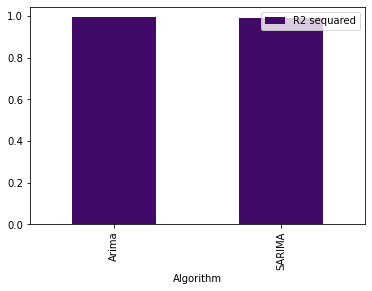

In [33]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'], 'R2 sequared': [arima_test_rs]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'R2 sequared': [sarima_test_rs]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(0.8, 0.5, 2))
Result_Comp.plot(kind='bar', figsize=(6, 4),color=color)

In [36]:
y_test=np.array(test_data)
y_test=y_test.reshape(-1, 1)
predictions=np.array(predictions)
y_pred=predictions.reshape(-1, 1)
def mean_absolute_percentage_error(y_test, y_pred):
    mask = y_test != 0
    return (np.fabs(y_test - y_pred)/y_test)[mask].mean()
mape=mean_absolute_percentage_error(y_test,y_pred)
print('Mean absolute percentage error: ', mape)

Mean absolute percentage error:  0.05678150156922389


# Graph of MAE of each algorithm

<AxesSubplot:xlabel='Algorithm'>

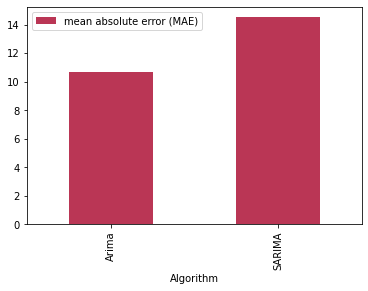

In [27]:
Result_Comp = pd.DataFrame({'Algorithm':['Arima'],'mean absolute error (MAE)': [arima_test_MAE]})
Result_Comp1 = pd.DataFrame({'Algorithm':['SARIMA'], 'mean absolute error (MAE)': [sarima_test_MAE]})

Result_Comp = pd.concat([Result_Comp, Result_Comp1])
Result_Comp.set_index("Algorithm",drop=True,inplace=True)
color = cm.inferno_r(np.linspace(0.5, 0.2, 7))
Result_Comp.plot(kind='bar', figsize=(6, 4),color=color)

### Now going to train Sarima on all data and then will fo FORECASTING

In [28]:
Sarima = SARIMAX(data['Close'],order=(4,1,0),seasonal_order=(1,1,1,12),enforce_invertibility=False, enforce_stationarity=False)
Sarima = Sarima.fit()

### FORECASTING

In [29]:
predictions = Sarima.predict(start=len(data), end= len(data)+42, dynamic= True)
predictions

2517    648.024325
2518    647.311466
2519    645.710380
2520    647.252780
2521    646.481404
2522    647.665471
2523    646.645628
2524    647.237674
2525    648.340216
2526    649.938673
2527    649.925865
2528    651.378009
2529    652.931027
2530    652.774714
2531    651.661145
2532    653.115292
2533    652.348824
2534    653.586330
2535    652.574030
2536    653.163566
2537    654.272560
2538    655.869933
2539    655.860171
2540    657.312675
2541    658.865769
2542    658.709632
2543    657.596184
2544    659.050338
2545    658.283883
2546    659.521402
2547    658.509106
2548    659.098643
2549    660.207639
2550    661.805012
2551    661.795251
2552    663.247755
2553    664.800849
2554    664.644712
2555    663.531264
2556    664.985418
2557    664.218964
2558    665.456482
2559    664.444186
Name: predicted_mean, dtype: float64

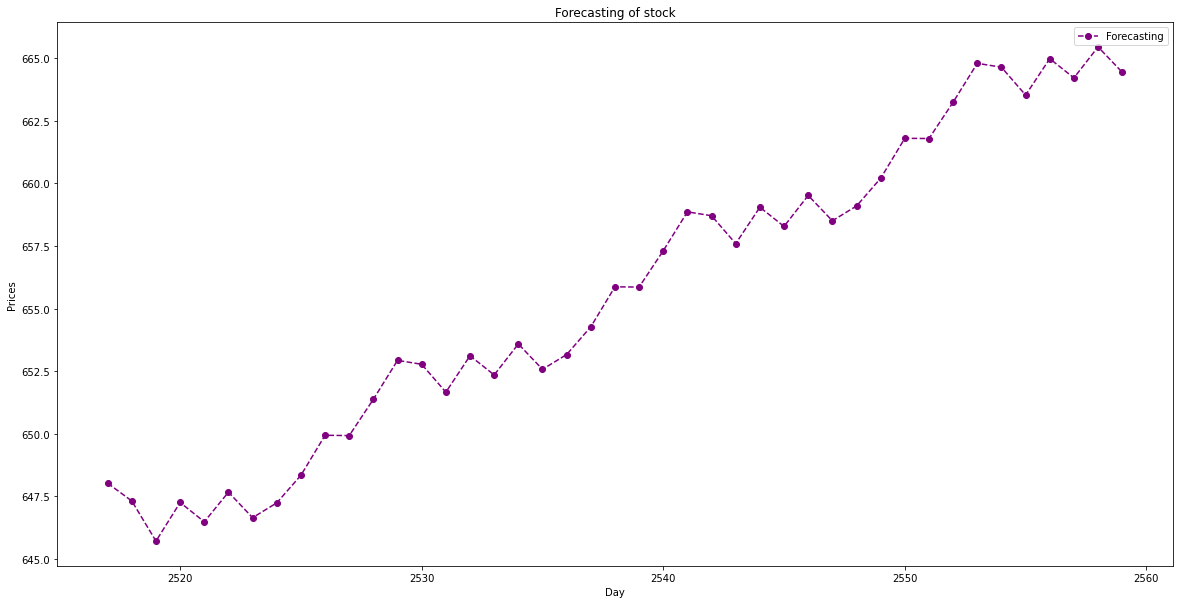

In [30]:
pred=pd.DataFrame(predictions)
pred=pred.rename(columns={'predicted_mean':'Forecasting'})
plt.figure(figsize=(20,10))
plt.plot(pred, color='purple', marker='o', linestyle='dashed',label='Forecasting')
plt.title('Forecasting of stock')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()